In [2]:
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from poisson_binomial import poisson_binomial_pmf as direct_convolution_local, poisson_binomial_pmf_direct
from scipy import stats,special
%config Completer.use_jedi = False

In [ ]:
X = np.random.randn(35,9000000)

In [ ]:
np.log(1e-16)

In [320]:
bins = np.array([0.0, 5.0, 16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
g = 0.5*(bins[1:]+bins[:-1])
Ng = 35
G_squared = np.square(g[:Ng,np.newaxis]-g[np.newaxis,:Ng])


L = np.exp(-G_squared/2.0/0.1**2)
invL = np.linalg.pinv(L)

K = np.exp(-G_squared/2.0/1.0**2)
Kt = np.copy(K)
Kt[Kt<1e-1] = 0.0
invKt = np.linalg.pinv(Kt)

mu = (np.arange(Ng)-Ng/2)*0.1

In [273]:
def soleymani(A,n_iter = 50, order='three',b=None):
    I = np.identity(A.shape[0])
    V = np.zeros((n_iter+1,*A.shape))
    
    # Initialise
    V[0] = A.T/(np.linalg.norm(A,1)*np.linalg.norm(A,np.inf))
    
    # Iterate
    for i_iter in range(n_iter):
        AV = np.dot(A,V[i_iter])
        if order == 'three':
            V[i_iter+1] = np.dot(V[i_iter],(3.0*I-np.dot(AV,3.0*I-AV)))
        elif order == 'three_alt':
            VA = np.dot(V[i_iter],A)
            V[i_iter+1] = np.dot(I+0.25*np.dot(I-VA,np.dot(3.0*I-VA,3.0*I-VA)),V[i_iter])
        elif order == 'sixth':
            V[i_iter+1] = np.dot(np.dot(V[i_iter],2.0*I-AV),np.dot(3.0*I-np.dot(AV,3.0*I-AV),I-np.dot(AV,I-AV)))
        elif order == 'seventh':
            W = -147.0*I+np.dot(AV,53.0*I+np.dot(AV,-11.0*I+AV))
            V[i_iter+1] = 0.25*np.dot(V[i_iter],32.0*I+np.dot(AV,-113.0*I+np.dot(AV,231.0*I+np.dot(AV,-301.0*I+np.dot(AV,259.0*I+np.dot(AV,W))))))
    
    if b is None:
        return V
    else:
        return np.dot(V[n_iter],b)

In [307]:
from scipy import linalg,sparse
np.dot(linalg.pinvh(K),mu)

array([-1.75000000e+00, -1.65000000e+00,  1.11604764e+00, -4.39556945e+00,
        4.37263908e+00, -1.90293929e+00,  2.68160310e-05,  1.08595484e-04,
       -1.27596653e-03, -4.83859474e-03, -1.28225391e-02, -2.72744941e-02,
       -5.04370239e-02, -8.44420310e-02, -1.31100735e-01, -1.91720038e-01,
       -2.66965128e-01, -3.56782174e-01, -8.30840066e+01,  9.62310419e+01,
        1.08687404e+02, -1.28795645e+02, -3.13041005e+01,  3.68972315e+01,
        8.22430446e-02, -3.26777224e+00,  1.30523314e+00,  1.13089682e+00,
        9.67139920e-01,  8.15366289e-01,  6.76228629e-01,  4.00231486e+00,
       -6.42979717e-01, -2.05810769e+00,  1.65000000e+00])

In [321]:
sparse.linalg.cgs(Kt,mu)

(array([-1.75000398e+00, -1.65000344e+00, -1.51575701e+00, -1.37186867e-02,
        -2.76899836e-02, -5.49193139e-02, -5.09541846e-02, -5.56122860e-03,
         4.45779955e-02,  3.23871437e-02,  5.84505939e-03, -6.55561519e-02,
        -5.28693994e+02,  1.28920002e+03, -7.97312816e+02,  1.55975266e+02,
        -4.48160334e+02, -1.94200659e+01,  4.32012443e+02,  2.90062018e+02,
        -3.89070400e+02,  1.17349332e+02, -1.43791370e+02, -5.03465871e+02,
         6.19538688e+02,  4.55151153e+02, -5.67733100e+02, -1.48383168e+02,
         1.84432605e+02, -1.22263563e+01,  1.49566140e+01,  1.36287355e-01,
         8.27131597e-02,  6.69185881e-02, -4.44943687e-02]),
 350)

In [295]:
sparse.linalg.spilu(K).solve(mu)

array([-1.75000000e+00, -1.65000000e+00, -9.22305043e+17,  6.51870000e+18,
        1.20602999e+20, -7.65944157e+20,  2.94318144e+21, -9.52352338e+21,
        3.62557291e+22, -1.14591109e+23,  1.61958304e+23, -6.78712734e+22,
       -1.01672038e+23,  2.03594178e+23, -1.82372263e+23,  1.00312050e+23,
       -3.46728975e+22,  6.83126340e+21, -5.35597138e+20,  1.27865847e+17,
       -1.04511884e+19,  1.67147127e+18, -1.08096681e+17, -1.30975192e+16,
        2.39850771e+15, -2.59313450e+13,  1.06291344e+13, -2.91523224e+12,
        4.92733533e+11, -3.92868968e+10,  2.23772548e+11, -8.01667165e+10,
        1.66852318e+10, -1.59701167e+09,  3.13414144e+03])

In [274]:
soleymani(K, n_iter = 50, order='three',b=mu)

array([-1.75000000e+00, -1.65000000e+00,  7.93779913e+01, -1.29841714e+03,
        7.97719641e+04, -5.06463283e+05,  1.89954816e+06, -5.70031545e+06,
        1.78408009e+07, -3.90385773e+07,  2.79942076e+07,  1.81297960e+07,
       -2.60422119e+07, -1.27915222e+07,  2.34111340e+07,  1.13413907e+07,
       -2.08691191e+07, -1.12529846e+07,  1.84885005e+07,  1.15149337e+07,
       -1.63547169e+07, -1.16227711e+07,  1.46481369e+07,  1.12734813e+07,
       -1.36425244e+07, -1.01611472e+07,  1.36772693e+07,  7.63063528e+06,
       -1.49773674e+07, -1.68076034e+06,  1.59686616e+07, -1.37555573e+07,
        5.34303956e+06, -8.44129232e+05,  1.82906278e+01])

In [257]:
invK = soleymani(K,n_iter =100, order='seventh')

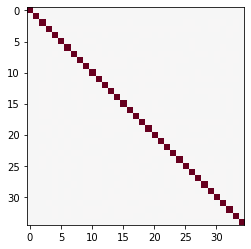

In [311]:
%matplotlib inline
from matplotlib.colors import LogNorm
plt.imshow(np.dot(invKt,Kt),cmap=plt.cm.RdBu_r,vmin=-1.0,vmax=1.0)

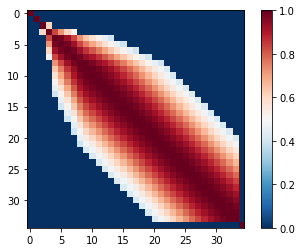

In [319]:
%matplotlib inline
from matplotlib.colors import LogNorm
plt.imshow(Kt,cmap=plt.cm.RdBu_r,vmin=0)
plt.colorbar()

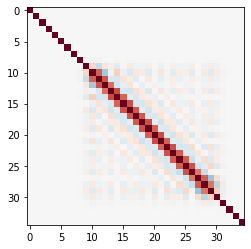

In [165]:
%matplotlib inline
from matplotlib.colors import LogNorm
plt.imshow(np.dot(invK,K),cmap=plt.cm.RdBu_r,vmin=-0.5,vmax=0.5)

In [264]:
%matplotlib widget

bins = np.array([0.0, 5.0, 16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
g = 0.5*(bins[1:]+bins[:-1])
Ng = 35
G_squared = np.square(g[:Ng,np.newaxis]-g[np.newaxis,:Ng])
G_abs= np.abs(g[:Ng,np.newaxis]-g[np.newaxis,:Ng])
np.random.seed(1)

def func(m,tau2,epsilon):
    if False:
        mu = np.sin(2.0*np.pi*np.arange(Ng)/40)#np.ones(Ng)
    elif False:
        mu = np.random.randn(Ng)
    elif True:
        mu = (np.arange(Ng)-Ng/2)*0.01
    else:
        mu = 0.3*np.ones(Ng)

    if False:
        K = np.exp(-G_squared/2.0/m**2)
        dKdm = K*G_squared/m**3
    elif True:
        alpha = 0.5
        K = (1.0+G_squared/(2.0*alpha*m**2))**(-alpha)
        dKdm = K*G_squared/m**3
    else:
        K = np.exp(-G_abs/m)
        dKdm = K*G_abs/m**2
    
    # adjustment
    if True:
        #epsilon = 1e-13
        delta = epsilon*np.diag(np.ones(Ng))
        K += delta
    
    # Solver
    if False:
        invKmu = np.linalg.solve(K,mu)
        J = np.linalg.solve(K,dKdm)
    elif False:
        invKmu = np.linalg.lstsq(K,mu,rcond=None)[0]
        J = np.linalg.lstsq(K,dKdm,rcond=None)[0] 
    else:
        invKmu = soleymani(K, n_iter = 50, order='seventh',b=mu)
        J = soleymani(K, n_iter = 50, order='seventh',b=dKdm)
    
    
    muinvKmu = np.dot(mu.T,invKmu)

    lnQ = -0.5*np.linalg.slogdet(K)[1]-0.5*muinvKmu/tau2 - (Ng/2)*np.log(2.0*np.pi*tau2)


    dJdtau2 = J/tau2

    dlnQdlnm = m*(-0.5*np.trace(J)+0.5*np.dot(invKmu.T,np.dot(dKdm,invKmu))/tau2)
    dlnQdlntau2 = 0.5*muinvKmu/tau2 - (Ng/2)
    dlnQdmu = -invKmu/tau2
    return lnQ

true_value = 28.614931639234705
plt.figure(figsize=(6,4),dpi=200)
M = np.arange(0.01,5.0,0.001)
tau2 = 0.3

Y = np.array([func(m,tau2,epsilon=0.0) for m in M])
print((true_value-Y.max())/true_value)
plt.plot(M,Y,lw=0.3)

Y = np.array([func(m,tau2,epsilon=1e-14) for m in M])
print((true_value-Y.max())/true_value)
plt.plot(M,Y,lw=0.3)



plt.yscale('symlog')
plt.xlabel('m')
plt.ylabel('log_prior_mu(m,tau2)')
#plt.savefig('./tmp.jpg',dpi=300,bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

In [71]:
func(1.0,1.0,epsilon=1e-12)

-71572139.16737612

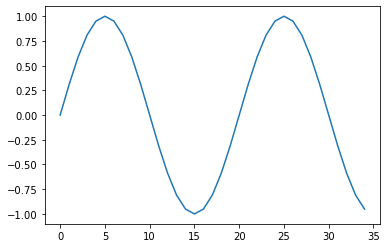

In [102]:
plt.plot(np.arange(Ng),np.sin(2.0*np.pi*np.arange(Ng)/20))

In [ ]:
np.linalg.solve(J,mu)

In [ ]:
plt.imshow(np.dot(J_inv,J))

# Log Prior

In [ ]:
from numba import njit
from math import ceil

@njit
def func_invKgYinvKt(Ng,Nt,lt,invKgY,invKgYinvKt):

    u = np.exp(-1.0/lt)
    u2 = u*u
    oneplusu2 = 1.0 + u2
    oneoveroneminusu2 = 1.0 / ( 1.0 - u2 )
    
    for ig in range(Ng):
        invKgYinvKt[ig,0] = (invKgY[ig,0] - u * invKgY[ig,1])*oneoveroneminusu2
        invKgYinvKt[ig,-1] = (invKgY[ig,-1] - u * invKgY[ig,-2])*oneoveroneminusu2
        for it in range(1,Nt-1):
            invKgYinvKt[ig,it] = ( oneplusu2 * invKgY[ig,it] - u * ( invKgY[ig,it-1] + invKgY[ig,it+1] ) )*oneoveroneminusu2
            
            
@njit
def func_YJt(Ng,Nt,lt,Y,result,log_eps=np.log(1e-16),safety_margin=10):
    
    u = np.exp(-1/lt)
    u2 = u*u
    
    M = safety_margin+ceil(-lt*log_eps)
    
    power_u = np.power(u,np.arange(M))
    
    lt2 = lt*lt
    
    for i in range(Ng):
        
        for l in range(Nt):
            
            res =  - (1.0+u2)*Y[i,l]/(1.0-u2)
            
            if l < M:
                res += u2*Y[i,0]*power_u[l]/(1.0-u2)
                
            if Nt-l-1 < M:
                res += u2*Y[i,-1]*power_u[Nt-l-1]/(1.0-u2)
            
            #res = (u2*( Y[i,0]*power_u[min(M,l)] + Y[i,-1]*power_u[min(M,Nt-l-1)] ) - (1.0+u2)*Y[i,l])/(1.0-u2)
            
            for j in range(max(0,l-M),min(Nt,l+M)):
                res += Y[i,j]*power_u[abs(l-j)]
                
            result[i,l] = res/lt2
    

def log_prior_x(x,mu,lt,lg,sigma2,G,Ng,Nt):
    
    # X is a (Ng,Nt) matrix
    # mu is a (Ng,) vector
    # sigma2, lt and lg are scalars
    # G2 is a (Ng,Ng) matrix
    
    Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
    
    G2 = np.square(G[:,np.newaxis]-G[np.newaxis,:])
    Kg = np.exp(-G2/lg/lg/2.0)
    dKg_dlg = G2*Kg/lg/lg/lg
    Jg = np.linalg.lstsq(np.dot(Kg.T,Kg),np.dot(Kg.T,dKg_dlg),rcond=None)[0]
    invKgY = np.linalg.lstsq(np.dot(Kg.T,Kg),np.dot(Kg.T,Y),rcond=None)[0]
    
    
    invKgYinvKt = np.zeros((Ng,Nt))
    func_invKgYinvKt(Ng,Nt,lt,invKgY,invKgYinvKt)
    
    u = np.exp(-1.0/lt)
    u2 = u*u
    logdetKg = np.linalg.slogdet(Kg)[1]
    logdetinvKt = -(Nt-1.0)*np.log( 1.0 - u2 )
    TrJg =  np.trace(Jg)
    TrJt = -2.0*(Nt-1.0)*u2/(1.0-u2)/lt/lt
    
    Y_invKgYinvKt = (Y*invKgYinvKt).sum()
    
    JgTY = np.dot(Jg.T,Y)
    JgTY_invKgYinvKt = (JgTY*invKgYinvKt).sum()
    
    YJt = np.zeros((Ng,Nt))
    func_YJt(Ng,Nt,lt,Y,YJt,log_eps=np.log(1e-16))
    YJt_invKgYinvKt = (YJt*invKgYinvKt).sum()
    
    lnP = -Ng*Nt*np.log(2.0*np.pi*sigma2)/2.0 + Ng*logdetinvKt/2.0 - Nt*logdetKg/2.0 - Y_invKgYinvKt/2.0/sigma2
    
    dlnP_dX = -invKgYinvKt/sigma2
    dlnP_dx = dlnP_dX.ravel()
    dlnP_dmu = -dlnP_dX.sum(axis=1)
    dlnP_dsigma2 = -Ng*Nt/2.0/sigma2 + Y_invKgYinvKt/2.0/sigma2/sigma2
    dlnP_dlt = -Ng*TrJt/2.0 + YJt_invKgYinvKt/2.0/sigma2
    dlnP_dlg = -Nt*TrJg/2.0 + JgTY_invKgYinvKt/2.0/sigma2
    #print(invKgY)
    #print(Kg,Y)
    
    return lnP, dlnP_dx, dlnP_dmu, dlnP_dlt, dlnP_dlg, dlnP_dsigma2

def log_prior_mu(mu,m,tau2):
    
    J = tau2*np.exp(-G_squared/2.0/m**2)
    J_inv = np.linalg.pinv(J)
    J_inv_mu = np.dot(J_inv,mu)
    
    lnQ = +0.5*np.linalg.slogdet(J_inv)[1]-0.5*np.dot(mu.T,J_inv_mu) - (Ng/2)*np.log(2.0*np.pi)
    
    dJdm = J*G2/m**3
    dJdtau2 = J/tau2

    dlnQdm = -0.5*np.trace(np.dot(J_inv,dJdm))+0.5*np.dot(J_inv_mu.T,np.dot(dJdm,J_inv_mu))
    dlnQdtau2 = -0.5*np.trace(np.dot(J_inv,dJdtau2))+0.5*np.dot(J_inv_mu.T,np.dot(dJdtau2,J_inv_mu))
    dlnQdmu = -J_inv_mu
    
    return lnQ, dlnQdmu, dlnQdm, dlnQdtau2

def log_prior_lengthscale(l):
    
    # InvGamma(1,2)
    
    lnA = np.log(2.0)-2.0*np.log(l)-2.0/l
    
    dlnAdl = 2.0*(1.0-l)/l/l
    
    return lnA, dlnAdl

def log_prior_variance(sigma2):
    
    # Gamma(1,1)
    
    lnS = - sigma2
    
    dlnSdsigma2 = - 1.0
    
    return lnS, dlnSsigma2

def log_likelihood(p):
    
    return 0.0, np.zeros(p.shape)

def log_posterior(args,Nh,Ng,Nt,G):
    
    # Unpack parameters
    ln_lt, ln_lg, ln_sigma2, ln_m, ln_tau2 = args[:Nh]
    mu = args[Nh:Nh+Ng]
    x = args[Nh+Ng:]
    
    # Transform parameters
    lt, lg, sigma2, m, tau2 = np.exp(ln_lg), np.exp(ln_lt), np.exp(ln_sigma2), np.exp(ln_m), np.exp(ln_tau2)
    p = 1.0/(1.0+np.exp(-x))
    
    ##### Priors
    
    ### Initialise values
    
    lnF = 0.0
    dlnF_dlt, dlnF_dlg, dlnF_dm = 0.0, 0.0
    dlnF_dsigma2, dlnF_dtau2 = 0.0, 0.0
    dlnF_dmu = np.zeros(Ng)
    dlnF_dx = np.zeros(Ng*Nt)
    dlnF_dp = np.zeros(Ng*Nt)
    
    
    ### Prior on x
    
    # Calculate quantities
    lnP, dlnP_dx, dlnP_dmu, dlnP_dlt, dlnP_dlg,dlnP_dsigma2 = log_prior_x(x,mu,lt,lg,sigma2,G,Ng,Nt)

    # Increment log posterior
    lnF += lnP

    # Increment gradients
    dlnF_dx += dlnP_dx
    dlnF_dmu += dlnP_dmu
    dlnF_dlt += dlnP_dlt
    dlnF_dlg += dlnP_dlg
    dlnF_dsigma2 += dlnP_dsigma2
    
    ### Prior on mu
    
    # Calculate quantities
    lnQ, dlnQ_dmu, dlnQ_dm, dlnQ_dtau2 = log_prior_mu(mu,m,tau2)
    
    # Increment log posterior
    lnF += lnQ
    
    # Increment gradients
    dlnF_dmu += dlnQ_dmu
    dlnF_dm += dlnQ_dm
    dlnF_dtau2 += dlnQ_dtau2
    
    ### Prior on lt, lg and m
    
    # Calculate quantities
    lnA, dlnA_dlt = log_prior_lengthscale(lt)
    lnB, dlnB_dlg = log_prior_lengthscale(lg)
    lnC, dlnC_dm  = log_prior_lengthscale(m)
    
    # Increment log posterior
    lnF += lnA
    lnF += lnB
    lnF += lnC
    
    # Increment gradients
    dlnF_dlt += dlnA_dlt
    dlnF_dlg += dlnB_dlg
    dlnF_dm  += dlnC_dm
    
    ### Prior on sigma2 and tau2
    
    # Calculate quantities
    lnS, dlnS_dsigma2 = log_prior_variance(sigma2)
    lnT, dlnT_dtau2 = log_prior_variance(tau2)
    
    # Increment log posterior
    lnF += lnS
    lnF += lnT
    
    # Increment gradients
    dlnF_dsigma2 += dlnS_dsigma2
    dlnF_dtau2 += dlnT_dtau2
    
    ##### Likelihood
    
    # Calculate quantities
    lnL, dlnL_dp = log_likelihood(p)
        
    # Increment log posterior
    lnF += lnL
    
    # Increment gradients
    dlnF_dp += dlnL_dp
    
    ##### Construct gradient with respect to input parameters
    
    # Initialise
    dlnF_dargs = np.zeros(Nh+Ng+Ng*Nt)
    
    # Correct for log-parameterisation
    dlnF_dln_lt = lt*dlnF_dlt
    dlnF_dln_lg = lg*dlnF_dlg
    dlnF_dln_m = m*dlnF_dm
    dlnF_dln_sigma2 = sigma2*dlnF_dsigma2
    dlnF_dln_tau2 = tau2*dlnF_dtau2
    
    # Correct for logit-parameterisation
    dlnF_dx += (1.0/p+1.0/(1.0-p))*dlnF_dp
    
    # Fill in values
    dlnF_dargs[0] = dlnF_dln_lt
    dlnF_dargs[1] = dlnF_dln_lg
    dlnF_dargs[2] = dlnF_dln_sigma2
    dlnF_dargs[3] = dlnF_dln_m
    dlnF_dargs[4] = dlnF_dln_tau2
    dlnF_dargs[Nh:Nh+M] = dlnF_dmu
    dlnF_dargs[Nh+M:] = dlnF_dx
    
    return lnF, dlnFdargs

# Log likelihood

In [ ]:
bins = np.array([0.0, 5.0, 16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
np.digitize(np.nan,bins)-1

In [ ]:
-np.log(1e-16)*2160

In [ ]:
p = np.array([0.3,0.6,0.2,0.1,0.9,0.5,0.3,0.2,0.8])
n = p.size
pmf = np.zeros(n+1)
direct_convolution_local(p,n,pmf)
print(pmf,pmf.sum())
print(poisson_binomial_pmf_direct(p))

In [ ]:
from numba import njit
            
@njit
def poisson_binomial_likelihood(k,probs,probslen,pmf,subpmf,likelihood,gradient):
    
    # Compute the pmf
    direct_convolution_local(probs,probslen,pmf)
    
    likelihood[:] = pmf[k]
    
    
    if k == 0:
        gradient_first_term,gradient_second_term=0.0,1.0
    elif k == probslen:
        gradient_first_term,gradient_second_term=1.0,0.0
    else:
        gradient_first_term,gradient_second_term=1.0,1.0
    
    for i in range(probslen):
        
        p = probs[i]
        oneoveroneminusp = 1.0/(1.0-p)
        
        subpmf[0] = pmf[0]*oneoveroneminusp
        for j in range(1,probslen):
            subpmf[j] = (pmf[j]-subpmf[j-1]*p)*oneoveroneminusp
        subpmf[probslen-1] = pmf[probslen]/p
        
        gradient[i] = gradient_first_term*subpmf[k-1]-gradient_second_term*subpmf[k]
        
    

k = 0
Ns = 500
subpmf = np.zeros(Ns)
gradient = np.zeros(Ns)
likelihood = np.zeros(1)
poisson_binomial_likelihood(k,p,n,pmf,subpmf,likelihood,gradient)

dp = 1e-4
print(likelihood[0])
print(poisson_binomial_pmf_direct(p)[k])
print(poisson_binomial_pmf_direct(p+dp*np.array([0,0,0,1,0,0,0,0,0]))[k])
print(likelihood[0]+dp*gradient[3])

In [ ]:
from numba import njit
            
@njit
def poisson_binomial_log_likelihood(k,probs,probslen,pmf,subpmf,log_likelihood,gradient):
    
    # Compute the pmf
    direct_convolution_local(probs,probslen,pmf)
    
    likelihood = pmf[k]
    log_likelihood[:] = np.log(likelihood)
    
    
    if k == 0:
        gradient_first_term,gradient_second_term=0.0,1.0
    elif k == probslen:
        gradient_first_term,gradient_second_term=1.0,0.0
    else:
        gradient_first_term,gradient_second_term=1.0,1.0
    
    for i in range(probslen):
        
        p = probs[i]
        oneoveroneminusp = 1.0/(1.0-p)
        
        subpmf[0] = pmf[0]*oneoveroneminusp
        for j in range(1,probslen):
            subpmf[j] = (pmf[j]-subpmf[j-1]*p)*oneoveroneminusp
        subpmf[probslen-1] = pmf[probslen]/p
        
        gradient[i] = (gradient_first_term*subpmf[k-1]-gradient_second_term*subpmf[k])/likelihood
        
    

k = 0
Ns = 500
subpmf = np.zeros(Ns)
gradient = np.zeros(Ns)
log_likelihood = np.zeros(1)
poisson_binomial_log_likelihood(k,p,n,pmf,subpmf,log_likelihood,gradient)

dp = 1e-7
print(log_likelihood[0])
print(np.log(poisson_binomial_pmf_direct(p)[k]))
print(log_likelihood[0]+dp*gradient[3])
print(np.log(poisson_binomial_pmf_direct(p+dp*np.array([0,0,0,1,0,0,0,0,0]))[k]))

In [ ]:
from numba import njit
import numpy as np
            
@njit
def poisson_binomial_log_likelihood_truncated(k,c,n,probs,log_likelihood,gradient,pmf,subpmf):
    
    # Assumes that c <= k <= n
    # k is the number of measurements reported by Gaia
    # c is the minimum number of measurements for a star to be reported by Gaia
    # n is the predicted number of visits by Gaia of that star
    # p is the list of measurement probabilities at each visit
    # log_likelihood is where you want the log likelihood to be stored (we can have this be an output of the function instead, if you prefer)
    # gradient is where you want the gradient to be stored (same as above)
    # pmf and subpmf are used for intermediate storage to avoid excessive memory allocation. Set these to be 1000 long and use them for every star.
    
    # Compute the pmf and log_likelihood
    direct_convolution_local(probs,n,pmf)
    
    likelihood = pmf[k]
    correction = 1.0 - np.sum(pmf[0:c])
    log_likelihood[:] = np.log(likelihood) - np.log(correction)
    
    # Branching to set terms in the loop
    if k == 0:
        gradient_first_term,gradient_second_term=0.0,1.0
    elif k == n:
        gradient_first_term,gradient_second_term=1.0,0.0
    else:
        gradient_first_term,gradient_second_term=1.0,1.0
    
    # Loop over the p's calculating the gradient
    for i in range(n):
        
        p = probs[i]
        oneoveroneminusp = 1.0/(1.0-p)
        
        subpmf[0] = pmf[0]*oneoveroneminusp
        for j in range(1,n):
            subpmf[j] = (pmf[j]-subpmf[j-1]*p)*oneoveroneminusp
        subpmf[n-1] = pmf[n]/p
        
        gradient[i] = (gradient_first_term*subpmf[k-1]-gradient_second_term*subpmf[k])/likelihood - subpmf[c-1]/correction
        
p = np.array([0.3,0.6,0.2,0.1,0.9,0.5,0.3,0.2,0.8])
n = p.size
k = 6
c = 5
Ns = 500
subpmf = np.zeros(Ns)
gradient = np.zeros(Ns)
log_likelihood = np.zeros(1)
poisson_binomial_log_likelihood_truncated(k,c,n,p,log_likelihood,gradient,pmf,subpmf)

dp = 1e-8
print('Predicted log-likelihood at p   ',log_likelihood[0])
print('Predicted log-likelihood at p+dp',log_likelihood[0]+dp*gradient[3])

pmf = poisson_binomial_pmf_direct(p)
likelihood = pmf[k]
correction = 1.0 - np.sum(pmf[0:c])
log_likelihood = np.log(likelihood) - np.log(correction)
print('True log-likelihood at p        ',log_likelihood)

pmf = poisson_binomial_pmf_direct(p+dp*np.array([0,0,0,1,0,0,0,0,0]))
likelihood = pmf[k]
correction = 1.0 - np.sum(pmf[0:c])
log_likelihood = np.log(likelihood) - np.log(correction)
print('True log-likelihood at p+dp     ',log_likelihood)


# Prior on mu - log prior and gradient

In [ ]:
bins = np.array([0.0, 5.0, 16.0, 17.0])
G = 0.5*(bins[1:]+bins[:-1])
G2 = np.square(G[:,np.newaxis]-G[np.newaxis,:])
M = bins.size-1

mu = np.array([-1.2,3.4,0.3])
m = 1.2
tau2 = 0.3**2.0


def log_prior(mu,m,tau2):
    J = tau2*np.exp(-G2/2.0/m**2)
    J_inv = np.linalg.pinv(J)
    J_inv_mu = np.dot(J_inv,mu)
    
    lnP = +0.5*np.linalg.slogdet(J_inv)[1]-0.5*np.dot(mu.T,J_inv_mu) - (M/2)*np.log(2.0*np.pi)
    
    dJdm = J*G2/m**3
    dJdtau2 = J/tau2

    dlnPdm = -0.5*np.trace(np.dot(J_inv,dJdm))+0.5*np.dot(J_inv_mu.T,np.dot(dJdm,J_inv_mu))
    dlnPdtau2 = -0.5*np.trace(np.dot(J_inv,dJdtau2))+0.5*np.dot(J_inv_mu.T,np.dot(dJdtau2,J_inv_mu))
    dlnPdmu = -J_inv_mu
    
    return lnP, dlnPdmu, dlnPdm, dlnPdtau2

def check(x,y,z):
    print(x,y,(x-y)/z)

lnP, dlnPdmu, dlnPdm, dlnPdtau2 = log_prior(mu,m,tau2)
lnP_truth = stats.multivariate_normal(mean=np.zeros(M),cov=J,allow_singular=True).logpdf(mu)
check(lnP,lnP_truth,lnP_truth)
h = 1e-7

lnP_dmu = log_prior(mu+h*np.array([1,0,0]),m,tau2)[0]
check(lnP+h*dlnPdmu[0],lnP_dmu,lnP_truth)

lnP_dm = log_prior(mu,m+h,tau2)[0]
check(lnP+h*dlnPdm,lnP_dm,lnP_truth)

lnP_dtau2 = log_prior(mu,m,tau2+h)[0]
check(lnP+h*dlnPdtau2,lnP_dtau2,lnP_truth)

# Prior on x

In [ ]:
Ng = 10
Nt = 15
x = np.random.randn(Ng*Nt,1)
mu = np.arange(Ng)/10.0
Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))

t = np.arange(Nt)
lt = 10.3
tau = np.abs(t[:,np.newaxis]-t[np.newaxis,:])
K = np.exp(-tau/lt)
invK = np.linalg.pinv(K)
dK_dlt = tau*K/lt/lt
result = np.einsum('ij,jk,kl->il',Y,invK,dK_dlt)
u = np.exp(-1/lt)
u2 = u*u

power_u = np.power(u,np.arange(Nt))

approx = np.zeros((Ng,Nt))

for i in range(Ng):
    for l in range(Nt):
        #approx[i,l] =  (Y[i,0]*np.power(u,l+2) + Y[i,-1]*np.power(u,Nt-l+1) - (1.0+u*u)*Y[i,l])/(1.0-u*u)
        approx[i,l] =  (u2*Y[i,0]*power_u[l] + u2*Y[i,-1]*power_u[Nt-l-1] - (1.0+u2)*Y[i,l])/(1.0-u2)
        for j in range(Nt):
            approx[i,l] += Y[i,j]*power_u[np.abs(l-j)]
approx = approx / (lt*lt)
#print(result)
#print(approx)
np.allclose(result,approx)

In [ ]:
from numba import njit
from math import ceil

@njit
def func_approx(Ng,Nt,lt,Y,result):
    
    u = np.exp(-1/lt)
    u2 = u*u
    power_u = np.power(u,np.arange(Nt))
    
    lt2 = lt*lt
    
    for i in range(Ng):
        for l in range(Nt):
            res =  (u2*Y[i,0]*power_u[l] + u2*Y[i,-1]*power_u[Nt-l-1] - (1.0+u2)*Y[i,l])/(1.0-u2)
            for j in range(Nt):
                res += Y[i,j]*power_u[abs(l-j)]
            result[i,l] = res/lt2
            
@njit
def func_truncate(Ng,Nt,lt,Y,result,log_eps=np.log(1e-16),safety_margin=10):
    
    u = np.exp(-1/lt)
    u2 = u*u
    
    M = safety_margin+ceil(-lt*log_eps)
    
    power_u = np.power(u,np.arange(M))
    
    lt2 = lt*lt
    
    for i in range(Ng):
        
        for l in range(Nt):
            
            res =  - (1.0+u2)*Y[i,l]/(1.0-u2)
            
            if l < M:
                res += u2*Y[i,0]*power_u[l]/(1.0-u2)
                
            if Nt-l-1 < M:
                res += u2*Y[i,-1]*power_u[Nt-l-1]/(1.0-u2)
            
            #res = (u2*( Y[i,0]*power_u[min(M,l)] + Y[i,-1]*power_u[min(M,Nt-l-1)] ) - (1.0+u2)*Y[i,l])/(1.0-u2)
            
            for j in range(max(0,l-M),min(Nt,l+M)):
                res += Y[i,j]*power_u[abs(l-j)]
                
            result[i,l] = res/lt2
            
def func_truth(Ng,Nt,lt,Y,result):
    
    t = np.arange(Nt)
    tau = np.abs(t[:,np.newaxis]-t[np.newaxis,:])
    K = np.exp(-tau/lt)
    invK = np.linalg.pinv(K)
    dK_dlt = tau*K/lt/lt
    result[:] = np.einsum('ij,jk,kl->il',Y,invK,dK_dlt)

In [ ]:
Ng = 35
Nt = 30000
x = np.random.randn(Ng*Nt,1)
mu = np.arange(Ng)/10.0
Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
lt = 10.2
result_approx = np.zeros((Ng,Nt))
result_truncate = np.zeros((Ng,Nt))
result_truth = np.zeros((Ng,Nt))

In [ ]:
if Nt < 250:
    %time func_approx(Ng,Nt,lt,Y,result_approx)
    %time func_truncate(Ng,Nt,lt,Y,result_truncate)
    %time func_truth(Ng,Nt,lt,Y,result_truth)
    #%timeit func_approx(Ng,Nt,lt,Y,result_approx)
    print(np.allclose(result_approx,result_truth),np.allclose(result_truncate,result_truth),np.allclose(result_approx,result_truncate))
elif Nt < 30000+1e-10:
    %time func_approx(Ng,Nt,lt,Y,result_approx)
    %time func_truncate(Ng,Nt,lt,Y,result_truncate)
    print(np.allclose(result_approx,result_truncate))
else:
    %time func_truncate(Ng,Nt,lt,Y,result_truncate)

In [ ]:
from numba import njit
from math import ceil

@njit
def func_invKgYinvKt(Ng,Nt,lt,invKgY,invKgYinvKt):

    u = np.exp(-1.0/lt)
    u2 = u*u
    oneplusu2 = 1.0 + u2
    oneoveroneminusu2 = 1.0 / ( 1.0 - u2 )
    
    for ig in range(Ng):
        invKgYinvKt[ig,0] = (invKgY[ig,0] - u * invKgY[ig,1])*oneoveroneminusu2
        invKgYinvKt[ig,-1] = (invKgY[ig,-1] - u * invKgY[ig,-2])*oneoveroneminusu2
        for it in range(1,Nt-1):
            invKgYinvKt[ig,it] = ( oneplusu2 * invKgY[ig,it] - u * ( invKgY[ig,it-1] + invKgY[ig,it+1] ) )*oneoveroneminusu2
            
            
@njit
def func_YJt(Ng,Nt,lt,Y,result,log_eps=np.log(1e-16),safety_margin=10):
    
    u = np.exp(-1/lt)
    u2 = u*u
    
    M = safety_margin+ceil(-lt*log_eps)
    
    power_u = np.power(u,np.arange(M))
    
    lt2 = lt*lt
    
    for i in range(Ng):
        
        for l in range(Nt):
            
            res =  - (1.0+u2)*Y[i,l]/(1.0-u2)
            
            if l < M:
                res += u2*Y[i,0]*power_u[l]/(1.0-u2)
                
            if Nt-l-1 < M:
                res += u2*Y[i,-1]*power_u[Nt-l-1]/(1.0-u2)
            
            #res = (u2*( Y[i,0]*power_u[min(M,l)] + Y[i,-1]*power_u[min(M,Nt-l-1)] ) - (1.0+u2)*Y[i,l])/(1.0-u2)
            
            for j in range(max(0,l-M),min(Nt,l+M)):
                res += Y[i,j]*power_u[abs(l-j)]
                
            result[i,l] = res/lt2
    

def log_prior_x(x,mu,sigma2,lt,lg,G2,Ng,Nt,lambd=1e-14,flag=True):
    
    # X is a (Ng,Nt) matrix
    # mu is a (Ng,) vector
    # sigma2, lt and lg are scalars
    # G2 is a (Ng,Ng) matrix
    
    Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
    
    if flag:
        Kg = np.exp(-G2/lg/lg/2.0)
        invKg = np.linalg.pinv(Kg)
        dKg_dlg = G2*Kg/lg/lg/lg
        Jg = np.dot(invKg,dKg_dlg)
        invKgY = np.dot(invKg,Y)
    elif False:
        Kg = np.exp(-G2/lg/lg/2.0)+lambd*np.diag(np.ones(Ng))
        invKg = np.linalg.pinv(Kg)
        dKg_dlg = G2*Kg/lg/lg/lg
        Jg = np.dot(invKg,dKg_dlg)
        invKgY = np.dot(invKg,Y)
    else:
        Kg = np.exp(-G2/lg/lg/2.0)
        dKg_dlg = G2*Kg/lg/lg/lg
        #Jg = np.linalg.lstsq(Kg,dKg_dlg,rcond=None)[0]
        #invKgY = np.linalg.lstsq(Kg,Y,rcond=None)[0]
        Jg = np.linalg.lstsq(np.dot(Kg.T,Kg)+lambd*np.diag(np.ones(Ng)),np.dot(Kg.T,dKg_dlg),rcond=None)[0]
        invKgY = np.linalg.lstsq(np.dot(Kg.T,Kg)+lambd*np.diag(np.ones(Ng)),np.dot(Kg.T,Y),rcond=None)[0]
        #np.linalg.lstsq(Kg,Y,rcond=None)[0]
    
    
    invKgYinvKt = np.zeros((Ng,Nt))
    func_invKgYinvKt(Ng,Nt,lt,invKgY,invKgYinvKt)
    
    u = np.exp(-1.0/lt)
    u2 = u*u
    logdetKg = np.linalg.slogdet(Kg)[1]
    logdetinvKt = -(Nt-1.0)*np.log( 1.0 - u2 )
    TrJg =  np.trace(Jg)
    TrJt = -2.0*(Nt-1.0)*u2/(1.0-u2)/lt/lt
    
    Y_invKgYinvKt = (Y*invKgYinvKt).sum()
    
    JgTY = np.dot(Jg.T,Y)
    JgTY_invKgYinvKt = (JgTY*invKgYinvKt).sum()
    
    YJt = np.zeros((Ng,Nt))
    func_YJt(Ng,Nt,lt,Y,YJt,log_eps=np.log(1e-16))
    YJt_invKgYinvKt = (YJt*invKgYinvKt).sum()
    
    lnP = -Ng*Nt*np.log(2.0*np.pi*sigma2)/2.0 + Ng*logdetinvKt/2.0 - Nt*logdetKg/2.0 - Y_invKgYinvKt/2.0/sigma2
    
    dlnP_dX = -invKgYinvKt/sigma2
    dlnP_dx = dlnP_dX.ravel()
    dlnP_dmu = -dlnP_dX.sum(axis=1)
    dlnP_dsigma2 = -Ng*Nt/2.0/sigma2 + Y_invKgYinvKt/2.0/sigma2/sigma2
    dlnP_dlt = -Ng*TrJt/2.0 + YJt_invKgYinvKt/2.0/sigma2
    dlnP_dlg = -Nt*TrJg/2.0 + JgTY_invKgYinvKt/2.0/sigma2
    #print(invKgY)
    #print(Kg,Y)
    
    return lnP, dlnP_dx, dlnP_dmu, dlnP_dsigma2, dlnP_dlt, dlnP_dlg


In [ ]:
def log_prior_x_testing(x,mu,sigma2,lt,lg,T,G,Ng,Nt):
    T = np.arange(Nt)
    Xg, Xt = np.meshgrid(G, T, sparse=False, indexing='ij')
    Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
    xg, xt, y = Xg.reshape((Ng*Nt,1)), Xt.reshape((Ng*Nt,1)), Y.reshape((Ng*Nt,1))
    K = sigma2 * np.exp(-np.abs(xt-xt.T)/lt) * np.exp(-np.square(xg-xg.T)/lg/lg/2.0)
    invK = np.linalg.pinv(K)
    lnP = -Ng*Nt*np.log(2.0*np.pi)/2.0 - np.linalg.slogdet(K)[1]/2.0 -0.5*np.dot(y.T,np.dot(invK,y))
    return lnP[0,0]

In [ ]:
np.random.seed(1)
g = np.array([0.0, 5.0, 16.0, 17.0, 18.0])#, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
G = 0.5*(g[1:]+g[:-1])
G2 = np.square(G[:,np.newaxis]-G[np.newaxis,:])
Ng = g.size-1
Nt = 2
T = np.arange(Nt)
x = np.random.randn(Ng*Nt,1)
mu = np.arange(Ng)/10.0
#Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
sigma2, lt, lg = 2.2,100.2,1.3
h = 1e-8

%time lnP, dlnP_dx, dlnP_dmu, dlnP_dsigma2, dlnP_dlt, dlnP_dlg = log_prior_x(x,mu,sigma2,lt,lg,G2,Ng,Nt)
#print('done')
lnP_test = log_prior_x_testing(x,mu,sigma2,lt,lg,T,G,Ng,Nt)

print('lnP\t\t',lnP,lnP_test)

lnP_test = log_prior_x_testing(x,mu,sigma2,lt+h,lg,T,G,Ng,Nt)
print('dlnP_dlt\t',lnP+h*dlnP_dlt,lnP_test) 

lnP_test = log_prior_x_testing(x,mu,sigma2,lt,lg+h,T,G,Ng,Nt)
print('dlnP_dlg\t',lnP+h*dlnP_dlg,lnP_test) 

lnP_test = log_prior_x_testing(x,mu,sigma2+h,lt,lg,T,G,Ng,Nt)
print('dlnP_dsigma2\t',lnP+h*dlnP_dsigma2,lnP_test)

lnP_test = log_prior_x_testing(x,mu+h,sigma2,lt,lg,T,G,Ng,Nt)
print('dlnP_dmu\t',lnP+(h*dlnP_dmu).sum(),lnP_test)

lnP_test = log_prior_x_testing(x+h,mu,sigma2,lt,lg,T,G,Ng,Nt)
print('dlnP_dx\t\t',lnP+(h*dlnP_dx).sum(),lnP_test)

In [ ]:
np.random.seed(1)
g = np.array([0.0, 5.0, 16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
#g = np.array([16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5])#, 25.0])

#g = np.arange(36)
#g[0] -= 100
G = 0.5*(g[1:]+g[:-1])
G2 = np.square(G[:,np.newaxis]-G[np.newaxis,:])
Ng = g.size-1
Nt = 2000
T = np.arange(Nt)
x = np.random.randn(Ng*Nt,1)
mu = np.arange(Ng)/30.0
#Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
sigma2, lt, lg = 2.2,100.2,0.3

%time lnP, dlnP_dx, dlnP_dmu, dlnP_dsigma2, dlnP_dlt, dlnP_dlg = log_prior_x(x,mu,sigma2,lt,lg,G2,Ng,Nt,lambd=0.0,flag=True)
print(lnP)

%time lnP, dlnP_dx, dlnP_dmu, dlnP_dsigma2, dlnP_dlt, dlnP_dlg = log_prior_x(x,mu,sigma2,lt,lg,G2,Ng,Nt,lambd=0.0,flag=False)
print(lnP)

In [ ]:
-449610475.01928824,-5679575041.718402

In [ ]:
import tqdm
lambd = np.logspace(-16,-3,100)
lnP = np.array([log_prior_x(x,mu,sigma2,lt,lg,G2,Ng,Nt,l)[0] for l in tqdm.tqdm(lambd)])

In [ ]:
np.linalg.slogdet(np.exp(-G2/lg/lg/2.0)+1e-11*np.diag(np.ones(Ng)))[1]

In [ ]:
plt.figure()
plt.plot(lambd,-lnP)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('regularisation')
plt.ylabel('lnP')
plt.savefig('./line.png',dpi=300,bbox_inches='tight')


In [ ]:
Y = x.reshape((Ng,Nt)) - mu.reshape((Ng,1))
Kg = np.exp(-G2/lg/lg/2.0)
invKg = np.linalg.pinv(Kg,hermitian=True)


In [ ]:
from scipy import linalg
p,l,u = linalg.lu(Kg)

In [ ]:
np.linalg.slogdet(np.dot(Kg.T,Kg))[1]

In [ ]:
r = np.linalg.matrix_rank(Kg)
INVKG = np.dot(vt.T[:,:r],np.dot(np.diag(1.0/s[:r]),u[:,:r].T))

plt.figure()
plt.imshow(np.dot(INVKG,Kg),cmap='RdBu_r',vmin=-0.5,vmax=0.5)

In [ ]:
plt.figure()
plt.imshow(Kg_mod)
plt.colorbar()

In [ ]:
np.linalg.slogdet(Kg),np.linalg.slogdet(Kg_mod)

In [ ]:
plt.figure()
#ax1.imshow(np.diag(np.ones(Ng)),cmap='RdBu_r',vmin=-0.5,vmax=0.5)
plt.imshow(np.dot(invKg,Kg),cmap='RdBu_r',vmin=-0.5,vmax=0.5)
#plt.savefig('./ugly.png',dpi=300,bbox_inches='tight')

In [ ]:
Lg

In [ ]:
Lg = np.linalg.cholesky(Kg+1e-15*np.diag(np.ones(Ng)))
invLg = np.linalg.pinv(Lg).T#,np.diag(np.ones(Ng)),rcond=None)[0]
invKg = np.dot(invLg,invLg.T)

In [ ]:
np.linalg.pinv(np.exp(-G2/lt/lt/2-np.linalg.slogdet(Kg)[1]/Nt))

In [ ]:
plt.figure()
plt.imshow(Kg)
plt.colorbar()

In [ ]:
np.linalg.s

In [ ]:
n = 4
l = 1.0/np.sqrt(2)
x = np.arange(n).reshape((n,1))
X2 = np.square(x-x.T)
u = np.exp(-1.0/l/l/2.0)
K = u**X2

In [ ]:
print(K)

In [ ]:
1.18102267/0.50123129

In [ ]:
invK = np.linalg.pinv(K)
print(invK)

In [ ]:
invK*(1.0-u**2)**3*(1+u**2)

# Investigating priors on hyperparameters

### Lengthscale

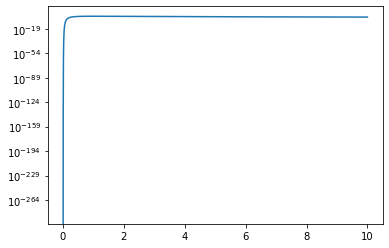

In [7]:
plt.figure()
x = np.linspace(np.exp(-14),10,10001)

# InvGamma(5,5)
plt.plot(x,stats.invgamma(a=1.0,scale=2.0).pdf(x))
plt.yscale('log')

### Variance

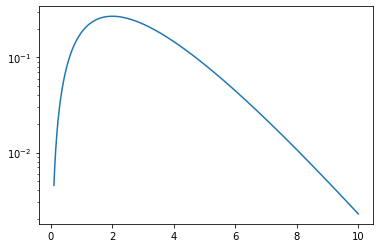

In [10]:
plt.figure()
x = np.linspace(0.1,10,10001)

# InvGamma(5,5)
plt.plot(x,stats.gamma(a=3.0,scale=1.0).pdf(x))
plt.yscale('log')

# Global

In [ ]:
bins = np.array([0.0, 5.0, 16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
G = 0.5*(bins[1:]+bins[:-1])

In [ ]:
G

In [ ]:
poisson_binomial_pmf_direct(np.array([0.4,0.9,0.96]))

In [ ]:
a = np.random.randn(3, 3)
b = np.random.randn(3, 1)
c = a*b

In [ ]:
c.shape

In [ ]:
#bins = np.array([0.0, 5.0, 16.0, 17.0, 18.0, 18.2, 18.4, 18.6, 18.8, 19.0, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 21.4, 21.5, 25.0])
bins = np.array([-2.0,-1.0,0.0, 1.0, 2.0])
G = 0.5*(bins[1:]+bins[:-1])
G_squared = np.square(G[:,np.newaxis]-G[np.newaxis,:])
M = bins.size-1
N = 10
p_groundtruth = special.expit(-G[:,np.newaxis]*np.ones((M,N)))
p_groundtruth[:,:3] = 0.0

stars = {}
times = np.arange(N).astype(np.int)
N_star = 123
for i in range(N_star):
    stars[i] = {}
    stars[i]['n'] = np.random.randint(N)
    stars[i]['g'] = np.random.randint(M)
    stars[i]['t'] = np.sort(np.random.choice(times,stars[i]['n'],replace=False))
    probs = p_groundtruth[stars[i]['g'],stars[i]['t']]
    pmf = poisson_binomial_pmf_direct(probs)
    stars[i]['k'] = np.random.choice(np.arange(0, stars[i]['n']+1), p=pmf)
    
#tmp_args = np.concatenate([np.array([4.0,0.5,4.0,0.5]),np.ones(N_bins),np.random.normal(0,1,N_bins*N_times)])

def log_prior_x(x,mu,l,sigma2):
    
    expml = np.exp(-l)
    expm2l = expml*expml
    
    d = x-mu
    
    A = d[0]**2+d[-1]**2
    B = np.sum(d[1:-1]**2)
    C = d[:-1]*d[1:]
    D = d[0] + d[-1]
    E = np.sum(d[1:-1])
    
    lnP = -N/2*np.log(sigma2) - (N-1)/2*np.log(1-expm2l) - N/2*np.log(2*np.pi) - ( A + (1+expm2l)*B - 2*expml*C )/(2*sigma2*(1-expm2l))
    
    dlnPdl = ((N-1)*sigma2*expm2l*(1-expm2l) + C*expml*(1+expm2l) - expm2l*(A+2*B))/(l*l*(1-expm2l)*(1-expm2l))
    
    dlnPdsigma2 = -N/2/sigma2 + ( A + (1+expm2l)*B - 2*expml*C )/(2*sigma2*sigma2*(1-expm2l))
    
    dlnPdmu =  (D+(1-expml)*E)/(sigma2*(1+xpml))
    
    dlnPdx = np.zeros(N)
    dlnPdx[0] = -(d[0]-expml*d[1])/(sigma2*(1-expm2l))
    for i in range(1,N-1):
        dlnPdx[i] = -((1+expm2l)*d[i]-expml*(d[i-1]+d[i+1]))/(sigma2*(1-expm2l))
    dlnPdx[-1] = -(d[-1]-expml*d[-2])/(sigma2*(1-expm2l))
    
    return lnP, dlnPdx, dlnPdmu, dlnPdl, dlnPdsigma2

def log_prior_mu(mu,m,tau2):
    
    J = tau2*np.exp(-G_squared/2.0/m**2)
    J_inv = np.linalg.pinv(J)
    J_inv_mu = np.dot(J_inv,mu)
    
    lnQ = +0.5*np.linalg.slogdet(J_inv)[1]-0.5*np.dot(mu.T,J_inv_mu) - (M/2)*np.log(2.0*np.pi)
    
    dJdm = J*G2/m**3
    dJdtau2 = J/tau2

    dlnQdm = -0.5*np.trace(np.dot(J_inv,dJdm))+0.5*np.dot(J_inv_mu.T,np.dot(dJdm,J_inv_mu))
    dlnQdtau2 = -0.5*np.trace(np.dot(J_inv,dJdtau2))+0.5*np.dot(J_inv_mu.T,np.dot(dJdtau2,J_inv_mu))
    dlnQdmu = -J_inv_mu
    
    return lnQ, dlnQdmu, dlnQdm, dlnQdtau2

def log_prior_lengthscale(l):
    
    # InvGamma(1,2)
    
    lnA = np.log(2.0)-2.0*np.log(l)-2.0/l
    
    dlnAdl = 2.0*(1.0-l)/l/l
    
    return lnA, dlnAdl

def log_prior_variance(sigma2):
    
    # Gamma(1,1)
    
    lnS = - sigma2
    
    dlnSdsigma2 = - 1.0
    
    return lnS, dlnSsigma2

def log_likelihood(p):
    lnL, dlnLdp = 0.0, np.zeros(M*N)
    
    for star in stars:
        L, dLdp = 0,0

def log_posterior(args):
    
    # Unpack parameters
    lnl, lnsigma2, lnm, lntau2 = args[:4]
    mu = args[4:4+M]
    x = args[4+M:]
    
    # Transform parameters
    l, sigma2, m, tau2 = np.exp(lnl), np.exp(lnsigma2), np.exp(lnm), np.exp(lntau2)
    p = 1.0/(1.0+np.exp(-x))
    
    ##### Priors
    
    ### Initialise values
    
    lnF = 0.0
    dlnFdl ,dlnFdm = 0.0, 0.0
    dlnFdsigma2, dlnFdtau2 = 0.0, 0.0
    dlnFdmu = np.zeros(M)
    dlnFdx = np.zeros(M*N)
    dlnFdp = np.zeros(M*N)
    
    
    ### Prior on x
    
    for g in range(M):
        
        # Calculate quantities
        lnP, dlnPdx, dlnPdmu, dlnPdl, dlnPdsigma2 = log_prior_x(x[g*N:(g+1)*N],mu[g],l,sigma2)
        
        # Increment log posterior
        lnF += lnP
        
        # Increment gradients
        dlnFdx[g*N:(g+1)*N] += dlnPdx
        dlnFdmu[g] += dlnPdmu
        dlnFdl += dlnPdl
        dlnFdsigma2 += dlnPdsigma2
    
    ### Prior on mu
    
    # Calculate quantities
    lnQ, dlnQdmu, dlnQdm, dlnQdtau2 = log_prior_mu(mu,m,tau2)
    
    # Increment log posterior
    lnF += lnQ
    
    # Increment gradients
    dlnFdmu += dlnQdmu
    dlnFdm += dlnQdm
    dlnFdtau2 += dlnQdtau2
    
    
    ### Prior on l and m
    
    # Calculate quantities
    lnA, dlnAdl = log_prior_lengthscale(l)
    lnB, dlnBdm = log_prior_lengthscale(m)
    
    # Increment log posterior
    lnF += lnA
    lnF += lnB
    
    # Increment gradients
    dlnFdl += dlnAdl
    dlnFdm += dlnBdm
    
    ### Prior on sigma2 and tau2
    
    # Calculate quantities
    lnS, dlnSdsigma2 = log_prior_variance(sigma2)
    lnT, dlnTdtau2 = log_prior_variance(tau2)
    
    # Increment log posterior
    lnF += lnS
    lnF += lnT
    
    # Increment gradients
    dlnFdsigma2 += dlnSdsigma2
    dlnFdtau2 += dlnTdtau2
    
    ##### Likelihood
    
    # Calculate quantities
    lnL, dlnLdp = log_likelihood(p)
        
    # Increment log posterior
    lnF += lnL
    
    # Increment gradients
    dlnFdp += dlnLdp
    
    ##### Construct gradient with respect to input parameters
    
    # Initialise
    dlnFdargs = np.zeros(4+M+M*N)
    
    # Correct for log-parameterisation
    dlnFdlnl = l*dlnFdl
    dlnFdlnm = m*dlnFdm
    dlnFdlnsigma2 = sigma2*dlnFdsigma2
    dlnFdlntau2 = tau2*dlnFdtau2
    
    # Correct for logit-parameterisation
    dlnFdx += (1.0/p+1.0/(1.0-p))*dlnFdp
    
    # Fill in values
    dlnFdargs[0] = dlnFdlnl
    dlnFdargs[1] = dlnFdlnsigma2
    dlnFdargs[2] = dlnFdlnm
    dlnFdargs[3] = dlnFdlntau2
    dlnFdargs[4:4+M] = dlnFdmu
    dlnFdargs[4+M:] = dlnFdx
    
    return lnF, dlnFdargs
    

# Poisson binomial likelihood

In [ ]:
p = np.array([0.3,0.6,0.2,0.1,0.9,0.5])
n = p.size
pmf = np.zeros(n+1)
poisson_binomial_pmf(p,n,pmf)
print(pmf,pmf.sum())
print(poisson_binomial_pmf_direct(p))

In [ ]:
from numba import njit
            
@njit
def poisson_binomial_likelihood(k,probs,probslen,pmf,subpmf,likelihood,gradient):
    
    # Compute the pmf
    poisson_binomial_pmf(probs,probslen,pmf)
    likelihood[0] = pmf[k]
    
    
    if k == 0:
        gradient_first_term,gradient_second_term=0.0,1.0
    elif k == probslen:
        gradient_first_term,gradient_second_term=1.0,0.0
    else:
        gradient_first_term,gradient_second_term=1.0,1.0
    
    for i in range(probslen):
        
        p = probs[i]
        oneoveroneminusp = 1.0/(1.0-p)
        
        subpmf[0] = pmf[0]*oneoveroneminusp
        for j in range(1,probslen):
            subpmf[j] = (pmf[j]-subpmf[j-1]*p)*oneoveroneminusp
        subpmf[probslen-1] = pmf[probslen]/p
        
        gradient[i] = gradient_first_term*subpmf[k-1]-gradient_second_term*subpmf[k]
        
    

k = 5
subpmf = np.zeros(n)
gradient = np.zeros(n)
likelihood = np.zeros(1)
poisson_binomial_likelihood(k,p,n,pmf,subpmf,likelihood,gradient)

dp = 1e-4
print(likelihood[0])
print(poisson_binomial_pmf_easy(p+dp*np.array([0,0,0,1,0,0]))[k])
print(likelihood[0]+dp*gradient[3])

In [ ]:
@njit
def poisson_binomial_log_likelihood(k,probs,probslen,pmf,subpmf,gradient):
    
    # Compute the pmf
    poisson_binomial_pmf(probs,probslen,pmf)
    likelihood = pmf[k]
    log_likelihood = np.log(likelihood)
    
    
    if k == 0:
        gradient_first_term,gradient_second_term=0.0,1.0
    elif k == probslen:
        gradient_first_term,gradient_second_term=1.0,0.0
    else:
        gradient_first_term,gradient_second_term=1.0,1.0
    
    for i in range(probslen):
        
        p = probs[i]
        oneoveroneminusp = 1.0/(1.0-p)
        
        subpmf[0] = pmf[0]*oneoveroneminusp
        for j in range(1,probslen):
            subpmf[j] = (pmf[j]-subpmf[j-1]*p)*oneoveroneminusp
        subpmf[probslen-1] = pmf[probslen]/p
        
        gradient[i] = gradient_first_term*subpmf[k-1]-gradient_second_term*subpmf[k]
        
    return log_likelihood

In [ ]:
dp = 1e-7*np.random.uniform(-1,1,6)
print(likelihood[0])
print(poisson_binomial_pmf_easy(p+dp)[k])
print(likelihood[0]+np.dot(dp,gradient))

In [ ]:
from numba import njit
            
@njit
def poisson_binomial_log_likelihood(k,probs,probslen,pmf,subpmf,log_likelihood,gradient):
    
    # Compute the pmf
    poisson_binomial_pmf(probs,probslen,pmf)
    likelihood = pmf[k]
    log_likelihood[0] = np.log(likelihood)
    
    
    if k == 0:
        gradient_first_term,gradient_second_term=0.0,1.0
    elif k == probslen:
        gradient_first_term,gradient_second_term=1.0,0.0
    else:
        gradient_first_term,gradient_second_term=1.0,1.0
    
    for i in range(probslen):
        
        p = probs[i]
        oneoveroneminusp = 1.0/(1.0-p)
        
        subpmf[0] = pmf[0]*oneoveroneminusp
        for j in range(1,probslen):
            subpmf[j] = (pmf[j]-subpmf[j-1]*p)*oneoveroneminusp
        subpmf[probslen-1] = pmf[probslen]/p
        
        gradient[i] = (gradient_first_term*subpmf[k-1]-gradient_second_term*subpmf[k])/likelihood
        
    

k = 4
subpmf = np.zeros(n)
gradient = np.zeros(n)
log_likelihood = np.zeros(1)
poisson_binomial_log_likelihood(k,p,n,pmf,subpmf,log_likelihood,gradient)

dp = 1e-7*np.random.uniform(-1,1,6)
print(log_likelihood[0])
print(np.log(poisson_binomial_pmf_easy(p+dp)[k]))
print(log_likelihood[0]+np.dot(dp,gradient))

In [ ]:
dKt_dl = tau*K/l/l
print(np.trace(np.dot(K_inv,dKt_dl)))
print(-2*u*u*(N-1)/(1-u*u))
    

In [ ]:
dKt_dl,u

In [ ]:
N = 5
x = np.arange(N)
l = 1.0
tau = np.abs(x[:,np.newaxis]-x[np.newaxis,:])
K = np.exp(-tau/l)
K_inv = np.linalg.pinv(K)
K_inv[np.abs(K_inv) < 1e-14] = 0.0
print(K_inv)
print(np.linalg.det(K_inv))
u = np.exp(-1.0/l)
a = 1
b = 1+u*u
c = -u
#print(a,b,c)
J_inv = np.zeros(K.shape)
J_inv[0,0] = J_inv[-1,-1] = a
for i in range(1,N-1):
    J_inv[i,i] = b
for i in range(0,N-1):
    J_inv[i,i+1] = J_inv[i+1,i] = c
J_inv /= 1-u*u
print(J_inv)
print(np.power(1/(1-u*u),N-1))

In [ ]:
slinalg.cholesky(G)

In [ ]:
G = np.exp(-tau/l)*tau/l/l
G_inv = np.linalg.pinv(G)
print(G_inv)

In [ ]:
np.linalg.inv(np.linalg.cholesky(G)).T

In [ ]:
def print_matrix(X):
    X[np.abs(X)<1e-14] = 0.0
    print(X)
print_matrix(np.linalg.cholesky(np.linalg.pinv(K)))
print_matrix(np.linalg.pinv(np.linalg.cholesky(K)))

In [ ]:
from scipy import linalg as slinalg

In [ ]:
slinalg.cholesky(inv_X)

In [ ]:
np.linalg.cholesky(K_inv)

In [ ]:
X = np.array([[2,1],[1,3]])
inv_X = np.linalg.inv(X)
chol_X = np.linalg.cholesky(X)
chol_inv_X = np.linalg.cholesky(inv_X)
inv_chol_X = np.linalg.inv(chol_X)
psuedo_chol_inv_X = inv_chol_X.T
print(X)
print(np.dot(chol_X,chol_X.T))
print(inv_X)
print(np.dot(chol_inv_X,chol_inv_X.T))
print(inv_chol_X)
print(chol_inv_X)
print(np.dot(psuedo_chol_inv_X,psuedo_chol_inv_X.T))
print(np.dot(chol_inv_X,chol_inv_X.T))

In [ ]:
inv_chol_X

In [ ]:
np.dot(chol_inv_X,chol_inv_X.T)

In [ ]:
np.dot(inv_chol_X.T,inv_chol_X)

In [ ]:
slinalg.inv(slinalg.cholesky(X).T)

In [ ]:
slinalg.cholesky(slinalg.inv(X)).T

In [ ]:
def true_det(i):
    return np.linalg.det(K_inv[:i,:i])

u = np.exp(1.0/l)
i = 6
print(np.power(u*u/(u*u-1),i))
print(true_det(i))
print(c*true_det(i-1)-a*a*true_det(i-2))

In [ ]:
1-1.0/(u*u)

In [ ]:
K_inv[:1+1,:1+1]

In [ ]:
np.linalg.det(K_inv[:5,:5])

In [ ]:
-np.exp(1.0/l)/(np.exp(2.0/l)-1)

In [ ]:
np.exp(2.0/l)/(np.exp(2.0/l)-1)